<a href="https://colab.research.google.com/github/PranavShashidhara/Netflix-Recommendation-system/blob/main/User_User_Colaberative_Filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
!pip install sortedcontainers

In [62]:
import pickle
import pandas as pd
import numpy as np
import os
from sortedcontainers import SortedList

In [63]:
with open('user2movie.json', 'rb') as f: # for user i there are a number of movies stored
  user2movie = pickle.load(f)
with open('movie2user.json', 'rb') as f: # for user a movie i there are M number of movies stored
  movie2user = pickle.load(f)
with open('usermovie2rating.json', 'rb') as f: # for a combination of user and movie a rating is present
  usermovie2rating = pickle.load(f)
with open('usermovie2rating_test.json', 'rb') as f: # for a combination of user and movie a rating is present for testing
  usermovie2rating_test = pickle.load(f)

In [64]:
# Setting different parameters
N = np.max(list(user2movie.keys())) + 1
m1 = np.max(list(movie2user.keys()))
m2 = np.max([m for [u, m], r in usermovie2rating_test.items()])
print(type(m1), type(m2))
M = max(m1, m2) + 1
print("N:", N, "M:", M)

if N > 10000:
  print("N =", N, "a you sure you want to continue?")
  print("Comment out these lines if so...")
  exit()

K = 25
limit = 5
neighbors = []
averages = []
deviations = []

<class 'numpy.int64'> <class 'numpy.int64'>
N: 1000 M: 200


Primary Equation implemented:

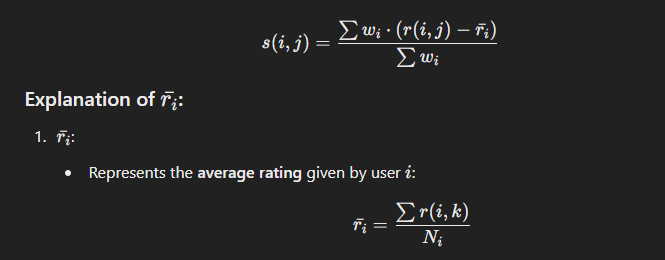

In [65]:
for i in range(N): # looping through different users
  movies_i = user2movie[i] # find the closest 25 neighbors to user i
  movies_i_set = set(movies_i) # get a unique set of all movies user i watched.

  ratings_i = {movie:usermovie2rating[(i, movie)] for movie in movies_i} # Getting the list of ratings for that user for all the movies he rated.
  avg_i = np.mean(list(map(float, ratings_i.values()))) # Getting average ratings for all the movies
  dev_i = {movie:(float(ratings_i) - avg_i) for movie, ratings_i in ratings_i.items()} # Calculating the required deviation
  dev_i_values = np.array(list(dev_i.values()))
  sigma_i = np.sqrt(dev_i_values.dot(dev_i_values)) #denominator is the absolute value of deviation vector

  averages.append(avg_i)
  deviations.append(dev_i)

  sl = SortedList()
  for j in range(N): # Recompute everything for user j
    if j != i:
      movies_j = user2movie[j]
      movies_j_set = set(movies_j)
      common_movies = (movies_i_set & movies_j_set)
      if len(common_movies) > limit: # Checking if there are enough common movies to make a prediction
        ratings_j = {movie:usermovie2rating[(j, movie)] for movie in movies_j}
        avg_j = np.mean(list(map(float, ratings_j.values())))
        dev_j = {movie:(float(ratings_j) - avg_i) for movie, ratings_j in ratings_j.items()}
        dev_j_values = np.array(list(dev_j.values()))
        sigma_j = np.sqrt(dev_j_values.dot(dev_j_values))

        numerator = sum(dev_i[m] * dev_j[m] for m in common_movies)
        w_ij = numerator / (sigma_i * sigma_j)
        sl.add((-w_ij, j))
        if len(sl) > K:
          del sl[-1]

  neighbors.append(sl)
  if i % 1 == 0:
    print(i)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75


<ipython-input-65-0c62c8b0fc18>:28: RuntimeWarning: invalid value encountered in scalar divide
  w_ij = numerator / (sigma_i * sigma_j)


76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331


In [66]:
def predict(i, m): # caculate the weighted sum of the deviations
  numerator = 0
  denominator = 0
  for neg_w, j in neighbors[i]:
    try:
      numerator += -neg_w * deviations[j][m] #since weights are stored as negative values make it positive
      denominator += abs(neg_w)
    except KeyError: #Since neighbors might now have rated the same movie we don't want to do the same lookup again and throw an exception.
      pass # if the deviations is not there then we can just throw an error and this is quicker than checking once and the getting the value.
  if denominator == 0:
    prediction = averages[i] # As cannot divide by 0
  else:
    prediction = numerator / denominator + averages[i]
  prediction = min(5, prediction)
  prediction = max(0.5, prediction) # max rating is 0.5
  return prediction
train_predictions = []
train_targets = []
for (i, m), target in usermovie2rating.items():
  prediction = predict(i, m)
  train_predictions.append(prediction)
  train_targets.append(target)

test_predictions = []
test_targets = []
for (i, m), target in usermovie2rating_test.items():
  prediction = predict(i, m)
  test_predictions.append(prediction)
  test_targets.append(target)

def mse(p, t):
  p = np.array(p)
  t = np.array(t, dtype = np.float64)
  return np.mean((p - t)**2)

print('train mse', mse(train_predictions, train_targets))
print('test mse', mse(test_predictions, test_targets))



train mse 0.5854430032915342
test mse 0.841967062073718


Calculating RMSE for your results:

Train RMSE:
0.5854
​
 ≈0.765


Test RMSE:
0.8420
​
 ≈0.917